# Validation against manual counts

In [136]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sys
import pandas as pd
import PIL
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import data, img_as_float
import scipy.stats as ss
import random

# Import wildcat
sys.path.append("wildcat.pytorch")
import wildcat.models

# Import wildcat mods
from unet_wildcat import *

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())
print("CUDA memory max alloc: %8.f MB" % (torch.cuda.max_memory_allocated() / 2.0**20))

PyTorch Version:  1.0.0
Torchvision Version:  0.2.2
CUDA status:  True
CUDA memory max alloc:     3063 MB


In [137]:
# Read the tangle counts dataframe
df=pd.read_csv('/home/pyushkevich/data/thon2019/tcount/manifest.csv')
df.head()

,id,slide_name,label_name,x,y,w,h,t_create,creator,t_edit,editor,specimen
0,12296,285359,finished_roi,43900.687514,29515.919898,2047.0,2047.0,1.568735e+09,pyushkevich,1.568990e+09,sandhitsu,HNL-11-15
1,12298,285359,candidate_roi,43981.792455,7207.740622,2047.0,2047.0,1.568735e+09,pyushkevich,1.568735e+09,pyushkevich,HNL-11-15
2,12299,285359,candidate_roi,17060.643622,22710.428107,2047.0,2047.0,1.568735e+09,pyushkevich,1.568735e+09,pyushkevich,HNL-11-15
3,12300,285359,candidate_roi,3927.646902,7876.170117,2047.0,2047.0,1.568735e+09,pyushkevich,1.568735e+09,pyushkevich,HNL-11-15
4,12301,285359,candidate_roi,34809.854645,28458.777831,2047.0,2047.0,1.568735e+09,pyushkevich,1.568735e+09,pyushkevich,HNL-11-15


Compute tangle counts per ROI

In [138]:
t_df = df[df['label_name']=='tangle']
r_df = df[df['label_name'] == 'finished_roi']
tc = []
for index, row in r_df.iterrows():
    
    # Get all tangles on this slide
    t_slide = t_df[t_df['slide_name']==row['slide_name']]
    t_rect = t_slide[['x','y','w','h']].values
    t_cx,t_cy = (t_rect[:,0]+t_rect[:,2]*0.5,t_rect[:,1]+t_rect[:,3]*0.5)    
    
    # Find the centers that are inside
    x0,y0,x1,y1 = row['x'],row['y'],row['x']+row['w'],row['y']+row['h']
    inside = np.all(np.stack((t_cx >= x0, t_cx <= x1, t_cy >= y0,t_cy <= y1)), axis=0)
    tc.append(np.sum(inside))
    
c_df = r_df[['id','slide_name','specimen']]
c_df['n_tangles']=tc
c_df.head()


/home/pyushkevich/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,id,slide_name,specimen,n_tangles
0,12296,285359,HNL-11-15,1
11,12308,285359,HNL-11-15,1
19,12316,285359,HNL-11-15,1
29,12327,285359,HNL-11-15,0
44,12342,285346,HNL-11-15,0


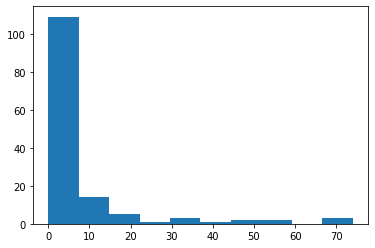

In [139]:
plt.hist(c_df['n_tangles'].values);

In [140]:
# Global properties
num_classes=2
input_size=224
input_size_wildcat=224
batch_size=16
batch_size_wildcat=16
resnet_flavor=18
data_dir = "/home/pyushkevich/data/thon2019/tcount"
model_dir = "/home/pyushkevich/resnet/thon2019/exp01"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#train_dir = "/home/pyushkevich/resnet/thon2019/exp01"

In [173]:
# Load each of the models in turn
i_fold=5
folds=os.listdir(model_dir)
f = folds[i_fold]
folds.remove(f)
(f,folds)

('fold_INDD116748',
 ['fold_INDD106312',
  'fold_INDD107677',
  'fold_INDD119294',
  'fold_HNL-11-15',
  'fold_HNL-29-18'])

In [174]:
# Load the common model (trained on all 6)
fold_model_file="/home/pyushkevich/resnet/thon2019/exp01/%s/model_%s_wcu_50_15epoch.dat" % (f,f)
model_main = resnet50_wildcat_upsample(2, pretrained=False, kmax=0.02, alpha=0.7, num_maps=4)
model_main.load_state_dict(torch.load(fold_model_file))
model_main.eval()
model_main = model_main.to(device)

In [175]:
# Drop all the rows that were in training
keep=[]
for index, row in c_df.iterrows():
    keep.append(("fold_%s" % (row['specimen'],)) not in folds)
k_df=c_df[keep]

In [176]:
# Main loop for scanning ROIs
tload=[]
tmaxcnt=[]
tpatch={}
ipatch={}
for index, row in k_df.iterrows():
    
    # Load the image
    fn='%s/samples/%d.png' % (data_dir,row['id'])
    img=PIL.Image.fromarray(np.uint8(np.asarray(PIL.Image.open(fn))[:,:,0:3]))
    ipatch[row['id']] = img
    
    # Size of the roi
    roi_dim = np.array(img.size)

    # Compute the desired size of input to wildcat
    wwc = (roi_dim * input_size_wildcat / 512).astype(int)

    # Resample the chunk for the two networks
    tran = transforms.Compose([
        transforms.Resize((wwc[0],wwc[1])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Select the model for this specimen
    sf = "fold_%s" % (row['specimen'],)
    if sf not in folds:
        sf = random.choice(folds)

    print('Sample %d   Specimen %s   Fold %s' % (row['id'],row['specimen'],sf))

    # Convert the read chunk to tensor format
    with torch.no_grad():

        # Apply transforms and turn into correct-size torch tensor
        chunk_tensor=torch.unsqueeze(tran(img),dim=0).to(device)

        # Forward pass through the wildcat model
        x_clas = model_main.forward_to_classifier(chunk_tensor)
        x_cpool = model_main.spatial_pooling.class_wise(x_clas)

        # Threshold
        x_thresh = (x_cpool[0,1,:,:] - x_cpool[0,0,:,:]).cpu().detach().numpy()
        x_thresh[x_thresh < 0.0] = 0.0
        
        tpatch[row['id']]=x_thresh;
        tload.append(x_thresh.sum())   
        
        # Count - add another threshold
        zz = x_thresh
        zz[zz < 1.0] = 0.0
        
        tmaxcnt.append(len(peak_local_max(zz, min_distance=10)))
        
k_df['tangle_load']=tload
k_df['tangle_maxcnt']=tmaxcnt



Sample 12701   Specimen HNL-32-18   Fold fold_HNL-11-15
Sample 12724   Specimen HNL-32-18   Fold fold_HNL-29-18
Sample 12730   Specimen HNL-32-18   Fold fold_INDD106312
Sample 12731   Specimen HNL-32-18   Fold fold_INDD106312
Sample 12737   Specimen HNL-32-18   Fold fold_INDD106312
Sample 12748   Specimen HNL-32-18   Fold fold_HNL-29-18
Sample 12749   Specimen HNL-32-18   Fold fold_INDD106312
Sample 12764   Specimen HNL-32-18   Fold fold_HNL-29-18
Sample 12776   Specimen HNL-32-18   Fold fold_INDD107677
Sample 12777   Specimen HNL-32-18   Fold fold_INDD107677
Sample 12802   Specimen HNL-32-18   Fold fold_HNL-11-15
Sample 12815   Specimen HNL-32-18   Fold fold_INDD107677
Sample 12831   Specimen HNL-32-18   Fold fold_INDD107677
Sample 12834   Specimen HNL-32-18   Fold fold_HNL-29-18
Sample 12840   Specimen HNL-32-18   Fold fold_INDD106312
Sample 12852   Specimen HNL-32-18   Fold fold_HNL-29-18
Sample 12876   Specimen HNL-34-18   Fold fold_INDD107677
Sample 12882   Specimen HNL-34-18   Fo

/home/pyushkevich/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/pyushkevich/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


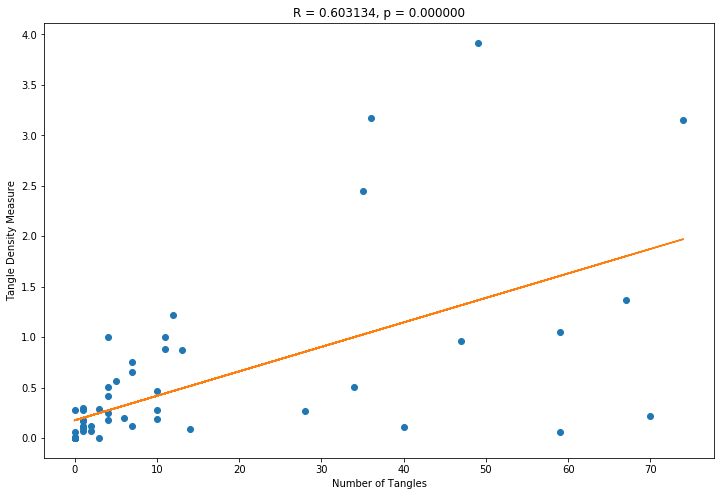

In [185]:
# Plot the stats
xi=k_df['n_tangles']
y=k_df['tangle_load'] / 448**2

slope, intercept, r_value, p_value, std_err = ss.linregress(xi,y)
line = slope*xi+intercept
plt.figure(figsize=(12,8))
plt.plot(xi,y,'o', xi, line)
plt.title('R = %f, p = %f' % (r_value, p_value));
plt.xlabel('Number of Tangles');
plt.ylabel('Tangle Density Measure');

In [186]:
ss.spearmanr(xi,y)

SpearmanrResult(correlation=0.7961312277257928, pvalue=2.885724978375677e-14)

In [187]:
ss.kendalltau(xi,y)

KendalltauResult(correlation=0.6386186996327475, pvalue=6.690561323907841e-12)

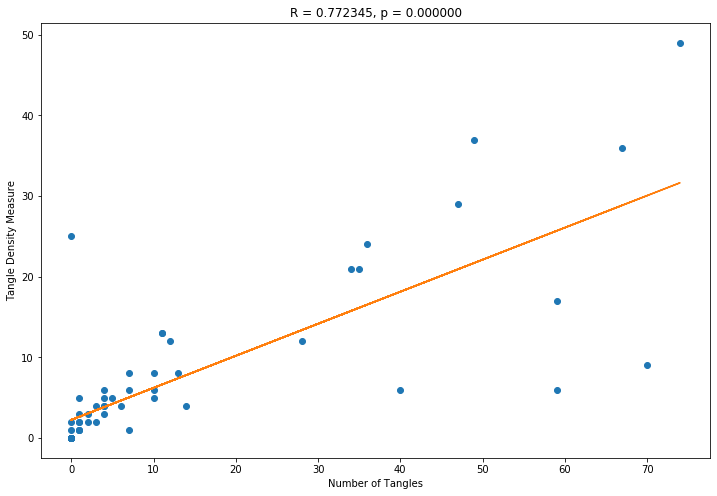

In [180]:
xi=k_df['n_tangles']
y=k_df['tangle_maxcnt']

slope, intercept, r_value, p_value, std_err = ss.linregress(xi,y)
line = slope*xi+intercept
plt.figure(figsize=(12,8))
plt.plot(xi,y,'o', xi, line)
plt.title('R = %f, p = %f' % (r_value, p_value));
plt.xlabel('Number of Tangles');
plt.ylabel('Tangle Density Measure');

In [188]:
ss.spearmanr(xi,y)

SpearmanrResult(correlation=0.7961312277257928, pvalue=2.885724978375677e-14)

In [189]:
ss.kendalltau(xi,y)

KendalltauResult(correlation=0.6386186996327475, pvalue=6.690561323907841e-12)

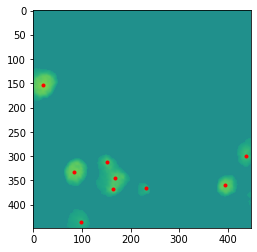

In [183]:
k=12701
zz=tpatch[k];
zz[zz < 1.0] = 0.0
ax=plt.imshow(zz,clim=(-10,10))
maxima=peak_local_max(zz, min_distance=10)
plt.plot(maxima[:, 1], maxima[:, 0], 'r.')

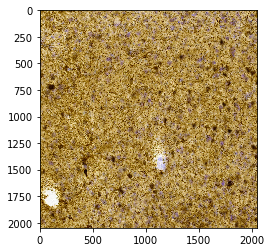

In [184]:
plt.imshow(ipatch[k])